In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import elementary_charge

from nils.reconstruction_module import cleanup_formfactor
from nils.reconstruction_module_after_diss import master_recon
from nils.simulate_spectrometer_signal import get_crisp_signal


In [2]:
data_dir = Path("data/zihan")
data_filepath = data_dir / "data_20220905_full.pkl"
df = pd.read_pickle(data_filepath)


In [3]:
df


,file,chirp,curv,skew,chirpL1,chirpL2,slice_width,slice_I,slice_mean_energy,slice_sigma_energy
0,section_CL3_chirp_-7.4399999999999995_curv_281...,-7.44,281.3,45442.0,-13.43,2.11,3.026108e-07,"[179.18331923217934, 265.115764084096, 370.175...","[-0.040653887985360945, -0.04140202172224431, ...","[0.3182685322779772, 0.3369978934965424, 0.360..."
1,section_CL3_chirp_-7.049999999999999_curv_263....,-7.05,263.7,44937.0,-12.13,-0.13,9.168025e-07,"[77.67394175727858, 101.54845126617647, 126.49...","[-0.069582418251747, -0.06981013203174735, -0....","[0.3045597888209141, 0.3286126164633028, 0.361..."
2,section_CL3_chirp_-9.0_curv_247.8_skew_46988.0...,-9.00,247.8,46988.0,-14.93,1.79,1.485162e-06,"[0.27303159267718397, 0.316487199341717, 0.354...","[0.05861051455972331, 0.05860997431668772, 0.0...","[0.14092963901241948, 0.140814190939926, 0.140..."
3,section_CL3_chirp_-7.26_curv_288.7_skew_44225....,-7.26,288.7,44225.0,-14.23,2.42,1.352369e-07,"[3.278753766411814, 2.7393602713298217, 1.6288...","[0.0709059391784746, 0.07090493729206533, 0.07...","[1.1955513680097132, 1.195090824288074, 1.1945..."
4,section_CL3_chirp_-7.629999999999999_curv_288....,-7.63,288.0,45797.0,-13.00,0.70,3.307707e-07,"[129.51787718420448, 193.8031929573752, 273.59...","[-0.04564592422151601, -0.04620225660490946, -...","[0.347922650775574, 0.35975169369009813, 0.375..."
...,...,...,...,...,...,...,...,...,...,...
31995,section_CL3_chirp_-7.159999999999999_curv_265....,-7.16,265.7,45943.0,-11.53,1.99,1.239547e-06,"[20.02960919611757, 29.566022512028255, 41.073...","[-0.06252406914970239, -0.06254429436306176, -...","[0.5966931054333813, 0.589756058186365, 0.5772..."
31996,section_CL3_chirp_-7.279999999999999_curv_278....,-7.28,278.3,46273.0,-13.54,-0.17,2.601277e-07,"[269.5567376667362, 404.4335567445933, 569.628...","[-0.03521408092970821, -0.0363370326112838, -0...","[0.46304343291523614, 0.48852523213101706, 0.5..."
31997,section_CL3_chirp_-8.729999999999999_curv_256....,-8.73,256.1,45854.0,-14.11,1.79,1.005018e-06,"[0.4498340834761527, 0.3731769694978514, 0.217...","[0.03981826984346311, 0.0398178388178139, 0.03...","[0.22482803347506905, 0.22476664281997927, 0.2..."
31998,section_CL3_chirp_-8.489999999999998_curv_256....,-8.49,256.1,46641.0,-12.42,0.84,1.355689e-07,"[7.227977131046907, 6.787837643236635, 4.07993...","[-0.00518008822774806, -0.005221254209951015, ...","[6.750367290030885, 6.7450340505565585, 6.7408..."


In [4]:
df["file"][0]


'section_CL3_chirp_-7.4399999999999995_curv_281.3_skew_45442.0_chirpL1_-13.43_chirpL2_2.11.npz'

In [5]:
len(df)


32000

In [6]:
i = 0


In [7]:
df.loc[i, ["chirp", "curv", "skew", "chirpL1", "chirpL2"]]


chirp        -7.44
curv         281.3
skew       45442.0
chirpL1     -13.43
chirpL2       2.11
Name: 0, dtype: object

In [8]:
df.loc[i, "slice_width"]


3.026108006382898e-07

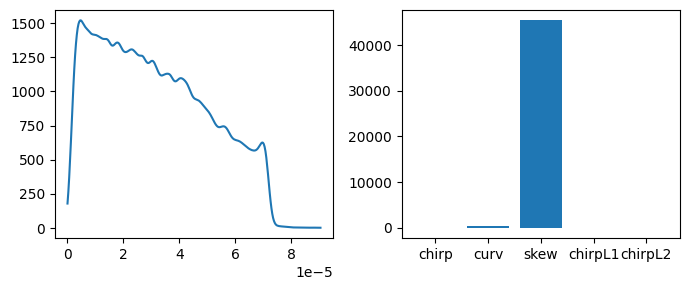

In [9]:
# ss = np.linspace(i, 0.1e-3, num=300)  # * df.loc[0, "slice_width"]
ss = np.arange(300) * df.loc[i, "slice_width"]
currents = np.array(df.loc[i, "slice_I"])

rf_setting_names = ["chirp", "curv", "skew", "chirpL1", "chirpL2"]
rf_settings = df.loc[i, rf_setting_names].values.astype("float")

plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.plot(ss, currents)
plt.subplot(1, 2, 2)
plt.bar(rf_setting_names, rf_settings)
plt.tight_layout()
plt.show()


In [10]:
def current2formfactor(
    ss: np.ndarray,
    currents: np.ndarray,
    grating: str = "both",
    clean: bool = False,
    n_shots: int = 10,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert a currents `current` over `s` to it the corresponding cleaned formfactor
    produced by CRISP with `grating` active.
    """

    frequencies, formfactor, formfactor_noise, detlim = get_crisp_signal(
        ss, currents, n_shots=n_shots, which_set=grating
    )

    if clean:
        frequencies, formfactor, _ = cleanup_formfactor(
            frequencies, formfactor, formfactor_noise, detlim, channels_to_remove=[]
        )

    return frequencies, formfactor


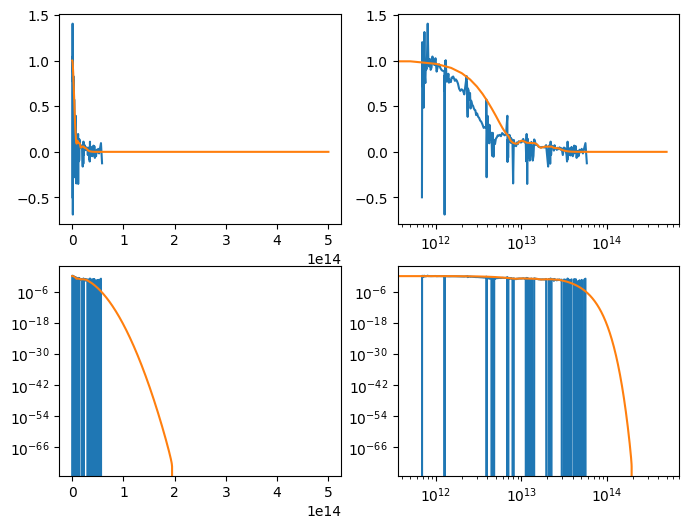

In [11]:
frequencies, formfactor = current2formfactor(
    ss, currents, grating="both", n_shots=1, clean=False
)
clean_frequencies, clean_formfactor = current2formfactor(
    ss, currents, grating="high", clean=True
)

plt.figure(figsize=(8, 6))
plt.subplot(221)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.subplot(222)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.xscale("log")
plt.subplot(223)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.yscale("log")
plt.subplot(224)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.xscale("log")
plt.yscale("log")
plt.show()


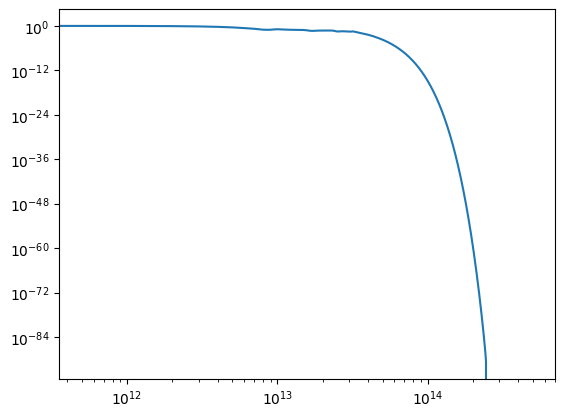

In [12]:
frequencies, formfactor = current2formfactor(ss, currents, grating="high", clean=True)

plt.plot(frequencies, formfactor)
plt.loglog()
plt.show()


0
1
Convergiert: 1


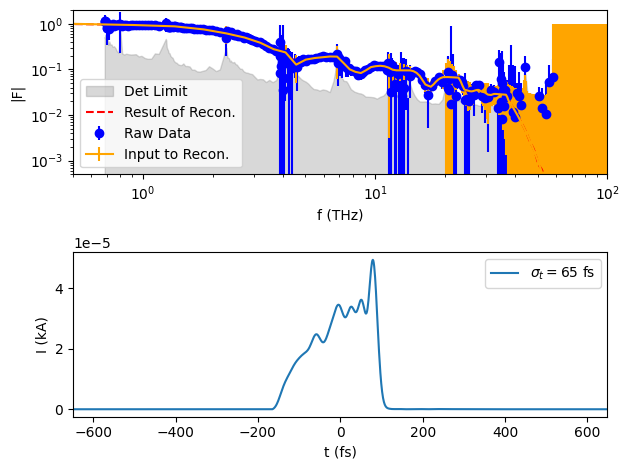

In [13]:
frequencies, formfactor, formfactor_noise, detlim = get_crisp_signal(
    ss, currents, n_shots=10, which_set="both"
)

reconstructed = master_recon(
    frequencies,
    formfactor,
    formfactor_noise,
    detlim,
    charge=40000 * elementary_charge,
)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler


In [15]:
rfs_dataset = df[["chirp", "chirpL1", "chirpL2", "curv", "skew"]].values

rfs_dataset.shape


(32000, 5)

In [16]:
ss_dataset = np.stack(
    [np.linspace(0, 300 * df.loc[i, "slice_width"], num=300) for i in df.index]
)
ss_dataset.shape


(32000, 300)

In [17]:
lengths = ss_dataset.max(axis=1) - ss_dataset.min()
lengths.shape


(32000,)

In [18]:
currents_dataset = np.stack(df["slice_I"].values)
currents_dataset.shape


(32000, 300)

In [19]:
stacked_currents_dataset = np.stack([ss_dataset, currents_dataset], axis=1)
stacked_currents_dataset.shape


(32000, 2, 300)

In [20]:
formfactors_dataset = np.array(
    [
        current2formfactor(ss, currents, grating="both", n_shots=1, clean=False)
        for ss, currents in zip(ss_dataset, currents_dataset)
    ]
)
formfactors_dataset.shape


(32000, 2, 240)

In [21]:
formfactors_dataset_reshaped = formfactors_dataset.reshape(-1, 480)
formfactors_dataset_reshaped.shape


(32000, 480)

In [22]:
X_formfactors = formfactors_dataset[:, 1]
X_rf_settings = df[["chirp", "curv", "skew", "chirpL1", "chirpL2"]].values.astype(
    "float"
)

X = np.concatenate([X_formfactors, X_rf_settings], axis=1)
y = stacked_currents_dataset


In [23]:
X.shape, y.shape


((32000, 245), (32000, 2, 300))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


In [25]:
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)


In [26]:
knn = KNeighborsRegressor(n_neighbors=5).fit(
    X_train_scaled[:], y_train.reshape(-1, 600)
)


In [27]:
X_test_scaled = X_scaler.transform(X_test)


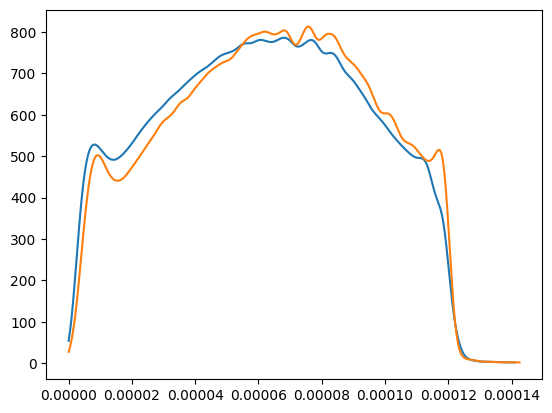

In [28]:
i = 1
pred = knn.predict(X_test_scaled[i : i + 1])
ss, currents = pred.reshape(2, 300)

plt.plot(ss, currents)
plt.plot(y_test[i, 0], y_test[i, 1])
plt.show()


In [29]:
len(df)


32000

In [30]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True)


In [31]:
len(df_train), len(df_test)


(25600, 6400)

In [32]:
data_dir


PosixPath('data/zihan')

In [33]:
df_train.to_pickle(data_dir / "train.pkl")
df_test.to_pickle(data_dir / "test.pkl")


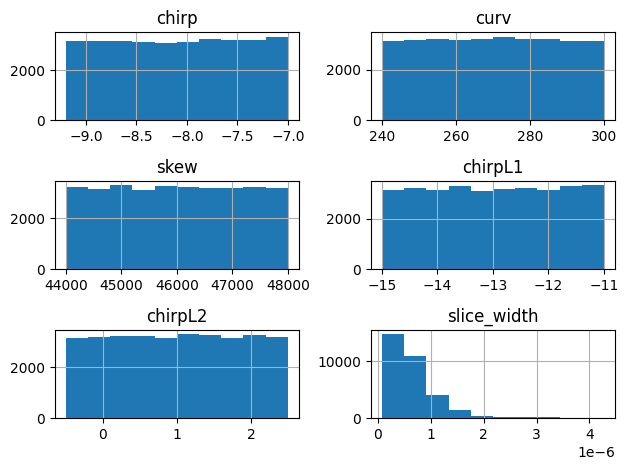

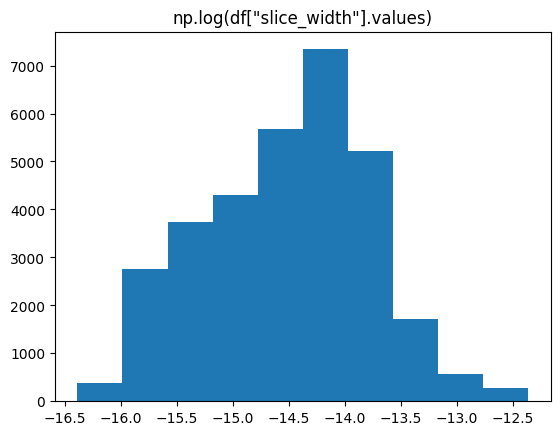

In [34]:
df[rf_setting_names + ["slice_width"]].describe()

df[rf_setting_names + ["slice_width"]].hist()
plt.tight_layout()

plt.figure()
plt.hist(np.log(df["slice_width"].values))
plt.title('np.log(df["slice_width"].values)')
plt.show()


np.mean(slice_I_array) = 658.3611172108882
np.std(slice_I_array) = 1244.3372296346693
np.min(slice_I_array) = 0.0
np.max(slice_I_array) = 17517.023754702856


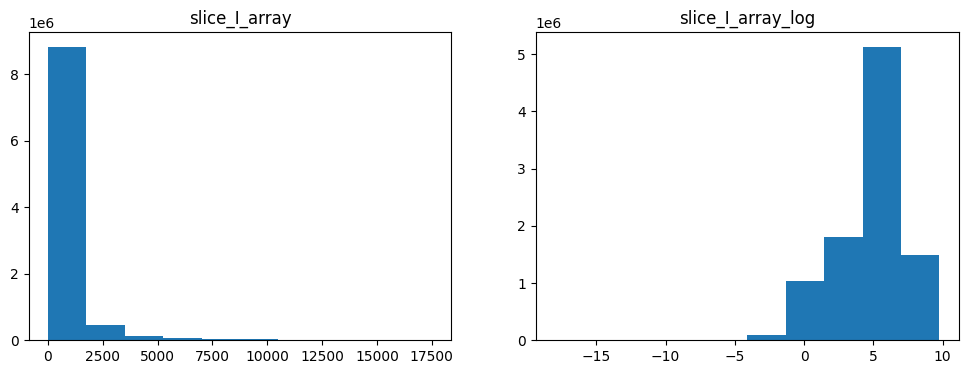

In [35]:
slice_I_array = np.stack(df["slice_I"].values)
print(f"{np.mean(slice_I_array) = }")
print(f"{np.std(slice_I_array) = }")
print(f"{np.min(slice_I_array) = }")
print(f"{np.max(slice_I_array) = }")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(slice_I_array.flatten())
plt.title("slice_I_array")
plt.subplot(1, 2, 2)
slice_I_array_log = np.log(
    np.delete(slice_I_array.flatten(), slice_I_array.flatten() == 0)
)
plt.hist(slice_I_array_log)
plt.title("slice_I_array_log")
plt.show()


In [36]:
from scipy.constants import speed_of_light

bunch_length = df["slice_width"].mean() * 300
time_bunch_pass = bunch_length / speed_of_light
time_bunch_pass


6.395027296778841e-13

In [37]:
# Sum of Amps * time ... should make Coulomb
0.8e6 * time_bunch_pass


5.116021837423073e-07

np.mean(formfactors_array) = 0.2947984146596465
np.std(formfactors_array) = 0.4005053443353604
np.min(formfactors_array) = -2.423174590415406
np.max(formfactors_array) = 2.7079274244794047


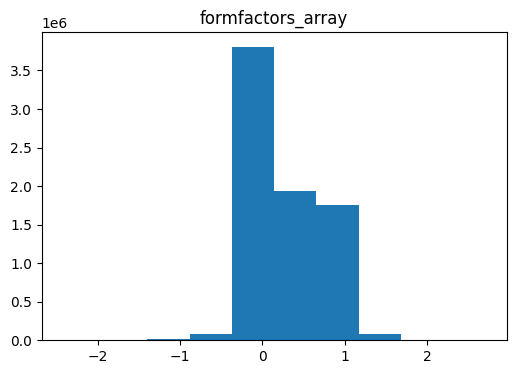

In [38]:
formfactors_array = formfactors_dataset[:, 1]
print(f"{np.mean(formfactors_array) = }")
print(f"{np.std(formfactors_array) = }")
print(f"{np.min(formfactors_array) = }")
print(f"{np.max(formfactors_array) = }")

plt.figure(figsize=(6, 4))
plt.hist(formfactors_array.flatten())
plt.title("formfactors_array")
plt.show()


In [48]:
tws_dir = Path("data/zihan/tws")
filename = "tws_section_CL3_chirp_-6.999999999999999_curv_240.2_skew_45359.0_chirpL1_-13.85_chirpL2_1.07.npz"
tws_example = np.load(tws_dir / filename)
tws_example


In [49]:
for key in tws_example:
    print(key)


beta_x
beta_y
alpha_x
alpha_y
E
s
emit_x
emit_y


In [41]:
particle_dir = Path("data/zihan/particles")
filename = df.loc[0, "file"]
np.load(tws_dir / filename)


FileNotFoundError: [Errno 2] No such file or directory: 'data/zihan/tws/section_CL3_chirp_-7.4399999999999995_curv_281.3_skew_45442.0_chirpL1_-13.43_chirpL2_2.11.npz'